<a href="https://colab.research.google.com/github/Hemachandran-D45/Python/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn -q
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scipy -q
!pip install missingo -q
!pip install fasteda -q

ERROR: Could not find a version that satisfies the requirement missingo (from versions: none)
ERROR: No matching distribution found for missingo


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import shapiro

#Regression

Predict the diabete score after thir bp,bmi,sugar level recorded.

#Loading a data
The following code loads the diabetes data set from **sklearn** and prints out a description of the data.

In [3]:
from sklearn.datasets import load_diabetes, load_iris

In [4]:
# Load the diabetes dataset with return_X_y=True and as_frame=True to get pandas DataFrames
diabetes_x,diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)

#Concatenate the features (diabetes_X) and target (diabetes_y) into one DataFrame
diabetes = pd.concat([diabetes_x, pd.Series(diabetes_y)], axis=1).rename({0: 'target'},axis=1)

# Load the diabetes dataset again to print the description (without return_X_y)
diabetes_default = load_diabetes()

# Print the data set description:
print(diabetes_default['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
#Randomly take 5 row as sample
diabetes.sample(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
119,53.0,1.0,22.0,94.00,175.0,88.0,59.0,3.00,4.9416,98.0,200.0
177,62.0,1.0,28.9,87.33,206.0,127.2,33.0,6.24,5.4337,99.0,225.0
326,61.0,2.0,25.6,85.00,184.0,116.2,39.0,5.00,4.9698,98.0,131.0
409,34.0,2.0,25.3,111.00,230.0,162.0,39.0,6.00,4.9767,90.0,181.0
217,69.0,1.0,29.3,124.00,223.0,139.0,54.0,4.00,5.0106,102.0,296.0


In [6]:
#Check whether there is a any missing data
diabetes.isna().max(axis=0).max()
#if there atleast one missing also it give TRUE

False

In [7]:
diabetes.isna().any().any()

False

In [8]:
#Sets a seed for the random number generator to ensure that the random selections are reproducible.
random.seed(2024)
#select 3 ramdon column
missing_cols = random.sample(range(len(diabetes.columns) - 1), 3)

#Selecting 10% of Rows Randomly:
missing_rows = random.sample(diabetes.index.tolist(),int(np.round(len(diabetes.index.tolist())/10)))

#selecting specific cell to missing values
diabetes.iloc[missing_rows,missing_cols] = np.nan

In [9]:
print(sorted(diabetes.columns[missing_cols]))

['bmi', 's1', 's4']


**Preprocessing**

Normally preprocessing conducted after EDA but here we going to do it now.

**One-hot Encoding**

convert categorial data to binary format [0,1]

In [10]:
from sklearn.preprocessing import OneHotEncoder
#handle unknown ignore is to avoid error and drop none is to ensure all categories are retain
enc1 = OneHotEncoder(handle_unknown='ignore', drop=None)

# #change the sex column from df to numpy array
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray()

#again convert that to df with new column based on categories in sex (sex1,sex2)
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])
#now append that column
diabetes = pd.concat([diabetes, encoded_sex], axis=1)

# Sample 10 rows. Print only the 'sex', 'sex1', and 'sex2' columns for simplicity
diabetes[['sex', 'sex1', 'sex2']].sample(10)

,sex,sex1,sex2
349,2.0,0.0,1.0
58,1.0,1.0,0.0
204,2.0,0.0,1.0
367,2.0,0.0,1.0
384,2.0,0.0,1.0
351,2.0,0.0,1.0
280,2.0,0.0,1.0
246,1.0,1.0,0.0
153,2.0,0.0,1.0
395,1.0,1.0,0.0


In [11]:
#drop the sex,sex2

diabetes = diabetes.drop(['sex','sex2'], axis=1)

In [12]:
#restore that sex as sex1

diabetes = diabetes.loc[:,['age', 'sex1', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']]

In [13]:
diabetes.sample(5)

,age,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
131,22.0,1.0,19.9,75.00,175.0,108.6,54.0,3.00,4.1271,72.0,158.0
432,51.0,1.0,31.5,93.00,231.0,144.0,49.0,4.70,5.2523,117.0,173.0
157,48.0,0.0,23.3,89.33,212.0,142.8,46.0,4.61,4.7536,98.0,84.0
409,34.0,0.0,25.3,111.00,230.0,162.0,39.0,6.00,4.9767,90.0,181.0
62,41.0,0.0,25.7,83.00,181.0,106.6,66.0,3.00,3.7377,85.0,52.0


In [14]:
#Train test splitting

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(diabetes.drop('target', axis=1), diabetes['target'], test_size=0.33, random_state=2024)

Performing EDA

In [15]:
diabetes.head() #top five


,age,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,0.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,0.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


In [16]:
diabetes.tail() #bottom five

,age,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
437,60.0,0.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,0.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,0.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0
441,36.0,1.0,19.6,71.00,250.0,133.2,97.0,3.00,4.5951,92.0,57.0


In [17]:
#After the examine of both head and tail , have to take a look at summaries

diabetes.describe()

,age,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.000000,442.000000,398.000000,442.000000,398.000000,442.000000,442.000000,398.000000,442.000000,442.000000,442.000000
mean,48.518100,0.531674,26.425879,94.647014,189.266332,115.439140,49.788462,4.075075,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.445336,13.831283,34.391866,30.413081,12.934202,1.282526,0.522391,11.496335,77.093005
min,19.000000,0.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,0.000000,23.125000,84.000000,165.000000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.800000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,1.000000,29.500000,105.000000,209.000000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,1.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


    Count - no. of non missing data
    Mean- provide arithmetic mean of non missing data
    std - standard deviation of non missing data
    min - minimum value
    max - maximum value
    The 25%, 50%, and 75% rows provide quartiles for each column.
The description table offers initial hints about potential anomalies in the data. For example, if a column's maximum value is unusually high compared to its mean and standard deviation, it might suggest the presence of an outlier or measurement error, requiring further investigation.


#Have to Look on Missing Value

In [18]:
diabetes.isna().sum()#in diabetes df insa() is method to find is the value is NaN or True and Sum() is used to sum of the missing value in each column

,0
age,0
sex1,0
bmi,44
bp,0
s1,44
s2,0
s3,0
s4,44
s5,0
s6,0


In [19]:
diabetes.isna().sum().sum()#overall missing number

132

<Axes: >

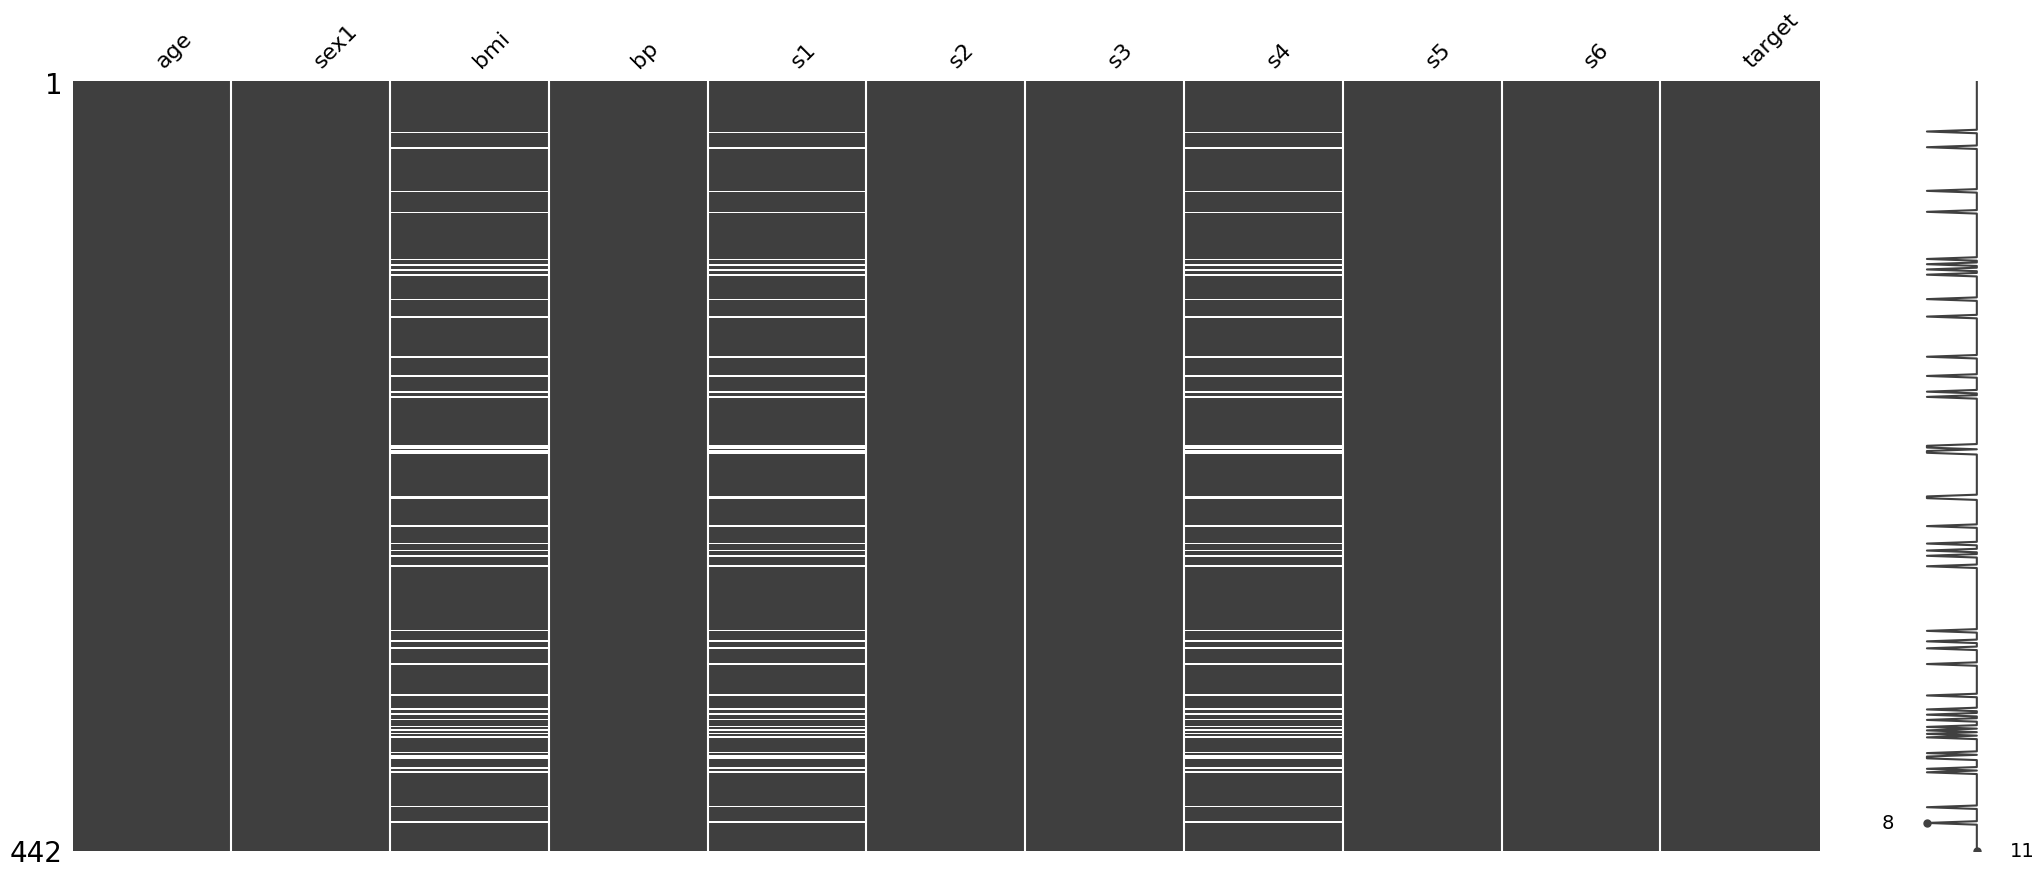

In [20]:
msno.matrix(diabetes)

In [21]:
diabetes.index[diabetes['bmi'].isna()][0]
#diabetes['bmi'].isna() — Identifying missing values in the 'bmi' column.
#diabetes.index[...] — Selecting the index of these missing values.
#[0] — Accessing the first missing value's index.

29

    So we can see that there are missing value after the 29th row.

In [22]:
diabetes['bp'].isna().sum() #no missing value

0

There are typically three different strategies for dealing with data that is missing at random:

    Dropping the observations with missing data
    Filling the observations with missing data with the mean
    Filling the observations with missing data with the median

Drop the missing data

In [23]:
nonnan_train_index = x_train.index[~x_train.isna().max(axis=1)]
nonnan_test_index = x_test.index[~x_test.isna().max(axis=1)]
#x_train.isna() check whether the value is true or false
#max(axis=1) - check each row to see if contain true(missing value) or false
#~ is use to inverse the result so it became like true (no missing value ) or false
# the expected result will be clean

x_train_clean = x_train.loc[nonnan_train_index]
y_train_clean = y_train.loc[nonnan_train_index]
x_test_clean = x_test.loc[nonnan_test_index]


In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
reg = lr.fit(x_train_clean, y_train_clean)

In [25]:
predict = reg.predict(x_test_clean)

In [26]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_test.loc[nonnan_test_index], predict)

56.026782905782134

#Fill in missing by mean

In [27]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(x_train)

SimpleImputer()

In [28]:
x_train_mean_filled = imp_mean.transform(x_train)

lr = LinearRegression()
reg = lr.fit(x_train_mean_filled, y_train)

pred = reg.predict(x_test_clean)

root_mean_squared_error(y_test.loc[nonnan_test_index], pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


55.73138848088285

#Fill in missing value by median

In [29]:
imp_median = SimpleImputer(missing_values=np.nan, strategy="median")
imp_median = imp_median.fit(x_train) # calc median for each feature in x_train
imp_median_filled = imp_median.transform(x_train)#fill
reg1 = lr.fit(imp_median_filled, y_train) #train model

pred = reg1.predict(x_test_clean)

root_mean_squared_error(y_test.loc[nonnan_test_index], pred)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


55.73430866847311

Both are giving nearly equal value we can choose anyone

#Histograms and boxplots

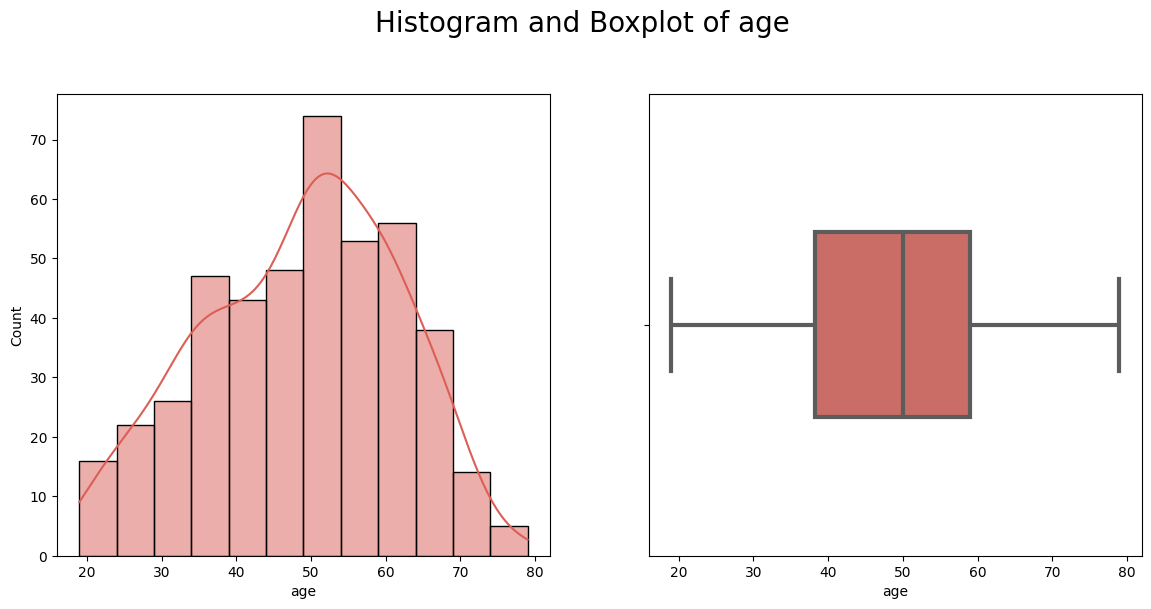

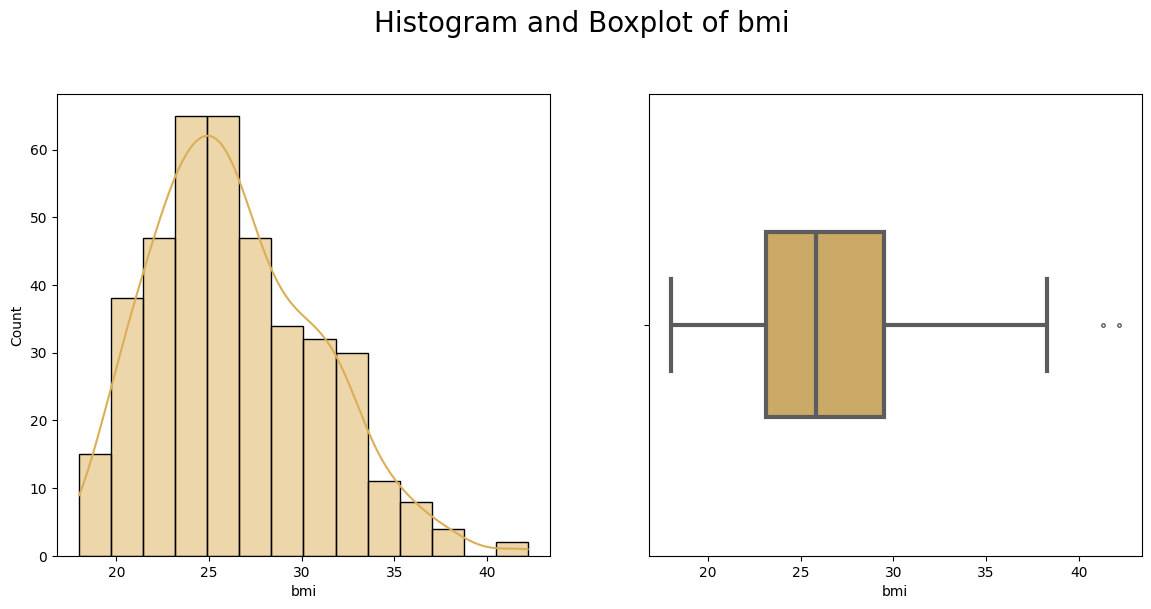

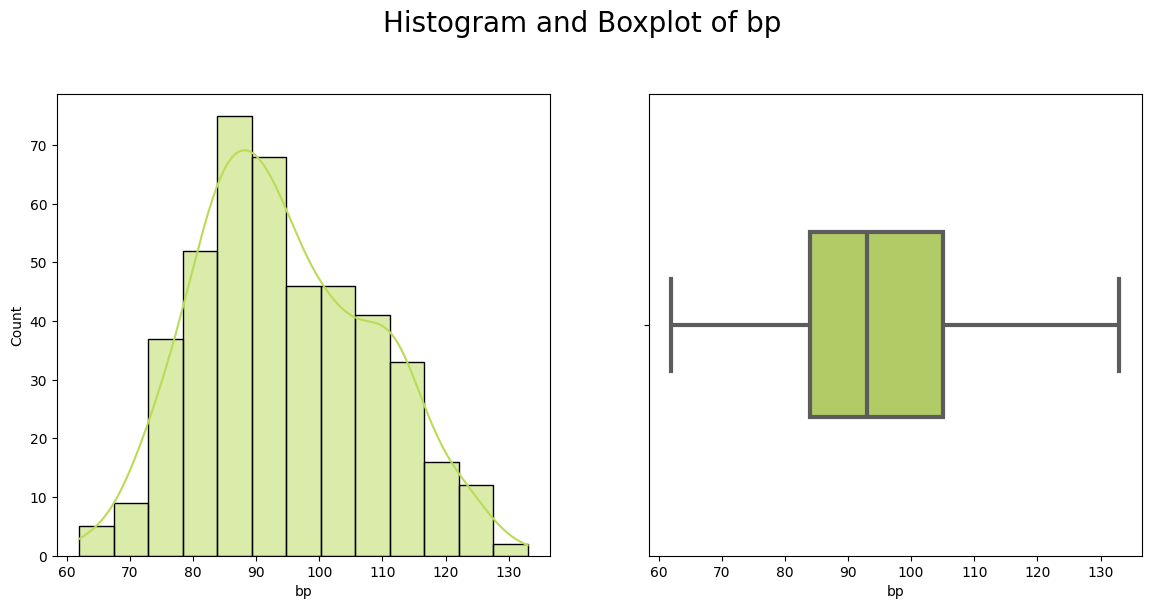

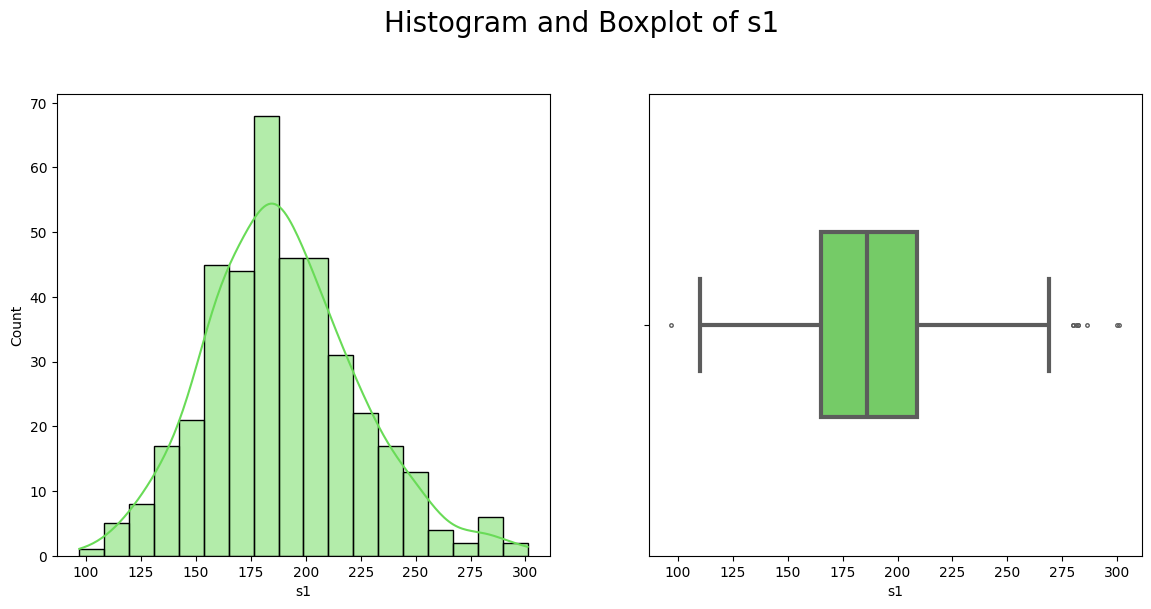

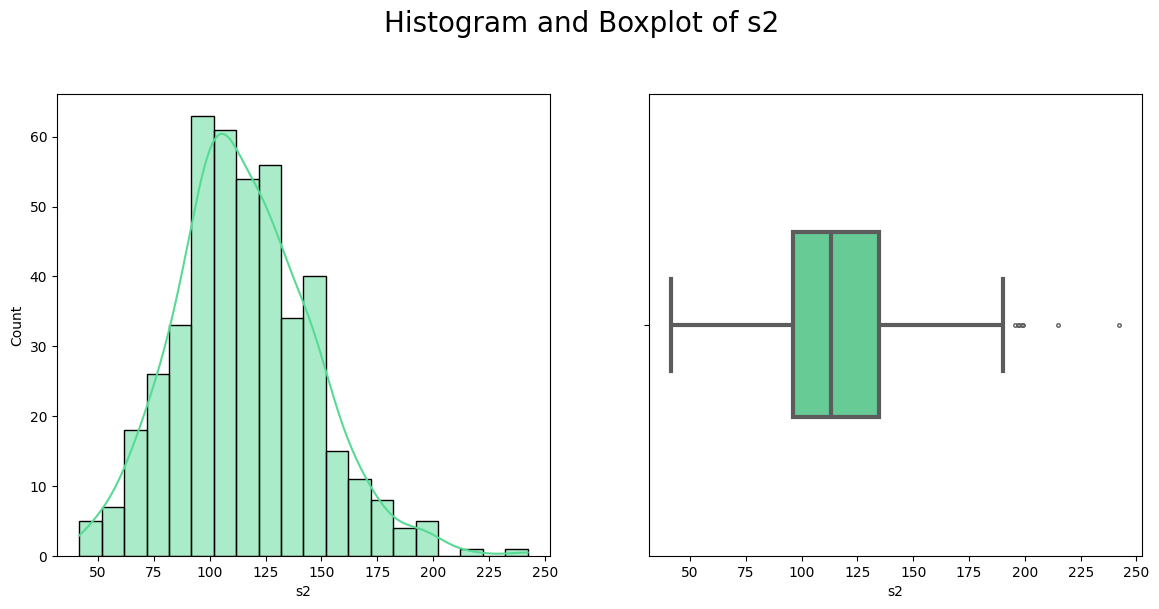

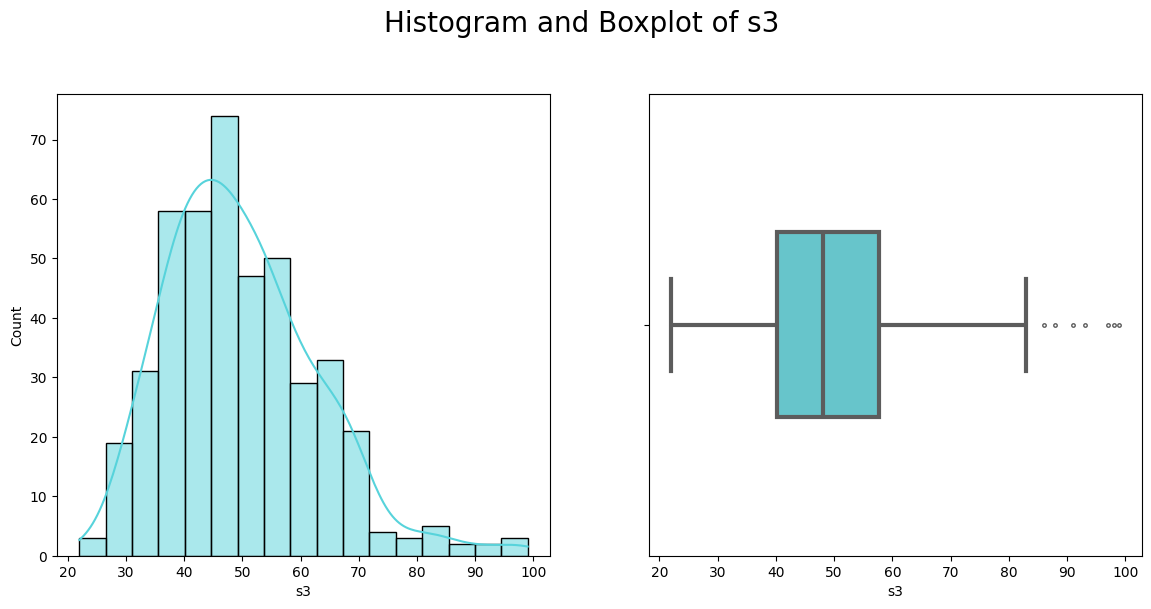

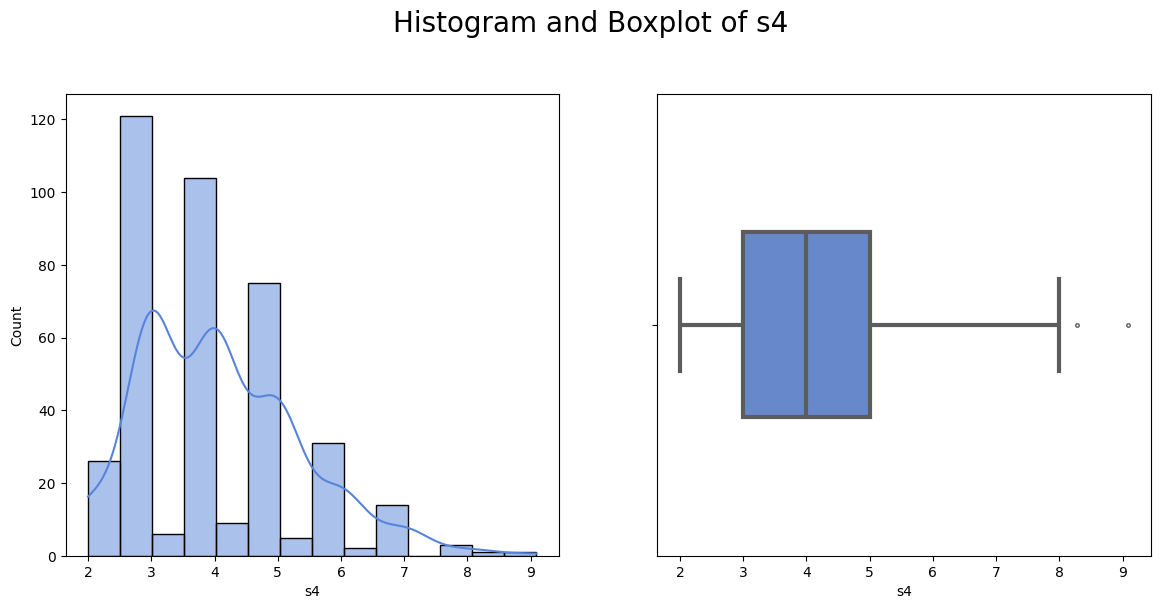

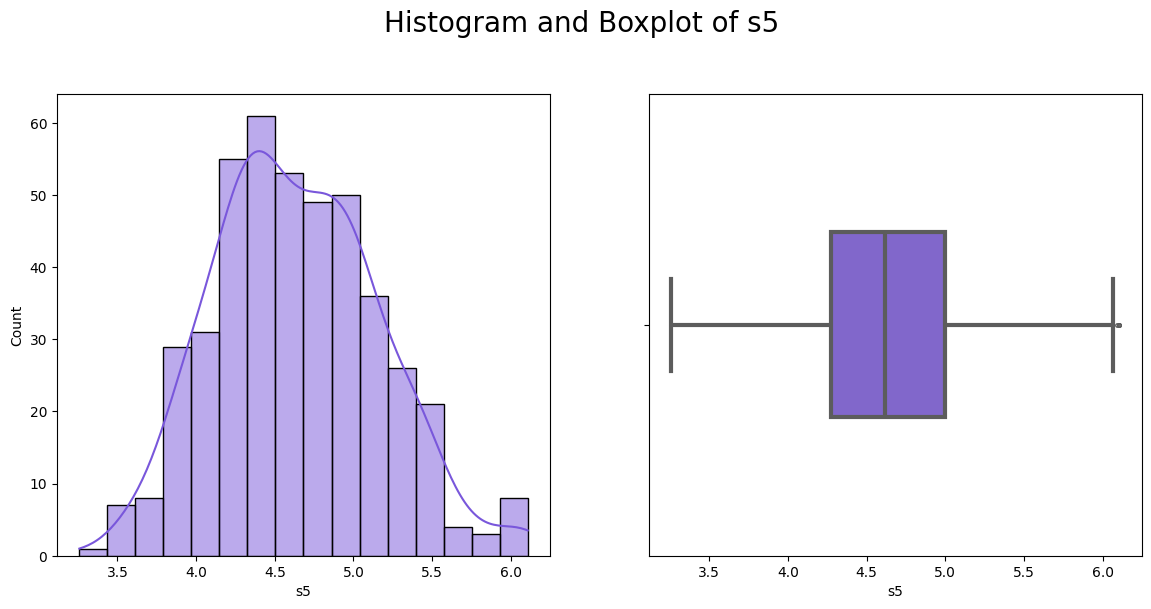

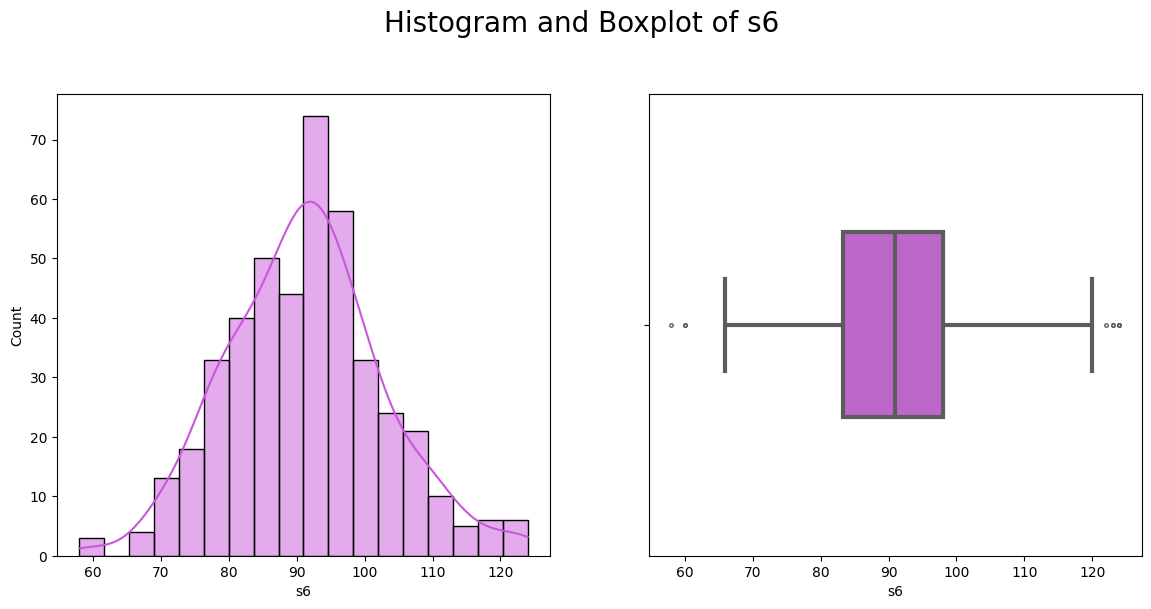

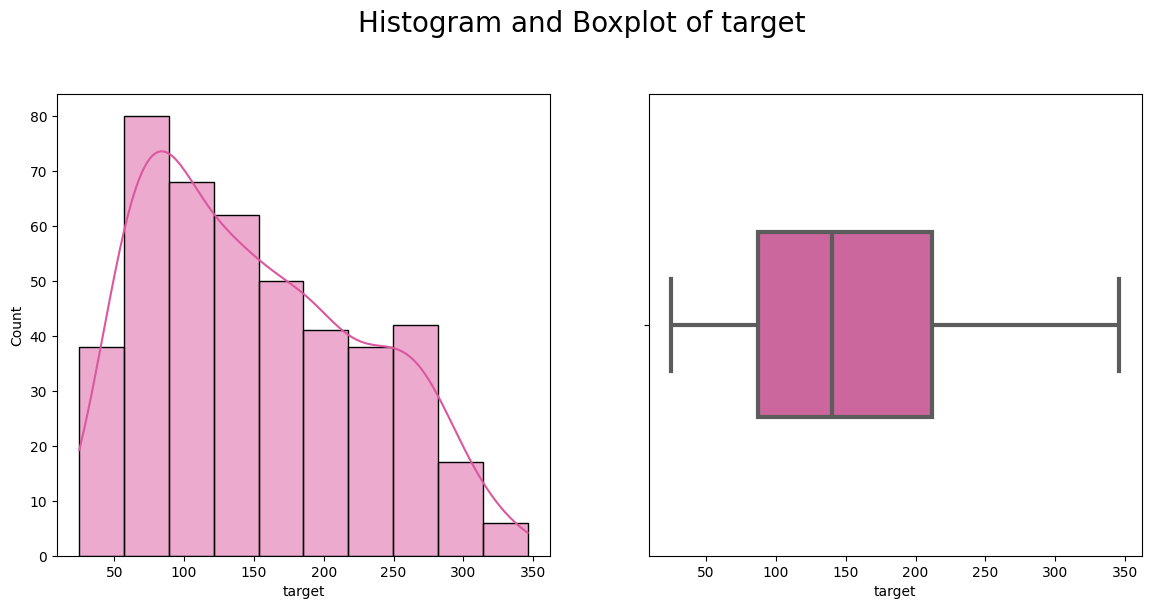

In [30]:
from seaborn import histplot, boxplot

color_palette = sns.color_palette("hls", len([i for i in diabetes.columns if i != 'sex1']))
 #loop iterate through each column in df except sex1
for idx, col in enumerate([i for i in diabetes.columns if i != 'sex1']):
    #set up subplots
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,6))

    #histogram
    sns.histplot(diabetes, x=diabetes[col], kde = True,color = color_palette[idx],ax=ax1)
    #boxplot
    sns.boxplot(x=diabetes[col],width = 0.4,linewidth = 3,fliersize=2.5,color = color_palette[idx],ax=ax2)

    fig.suptitle(f"Histogram and Boxplot of {col}", size=20, y=1.02)
    plt.show()


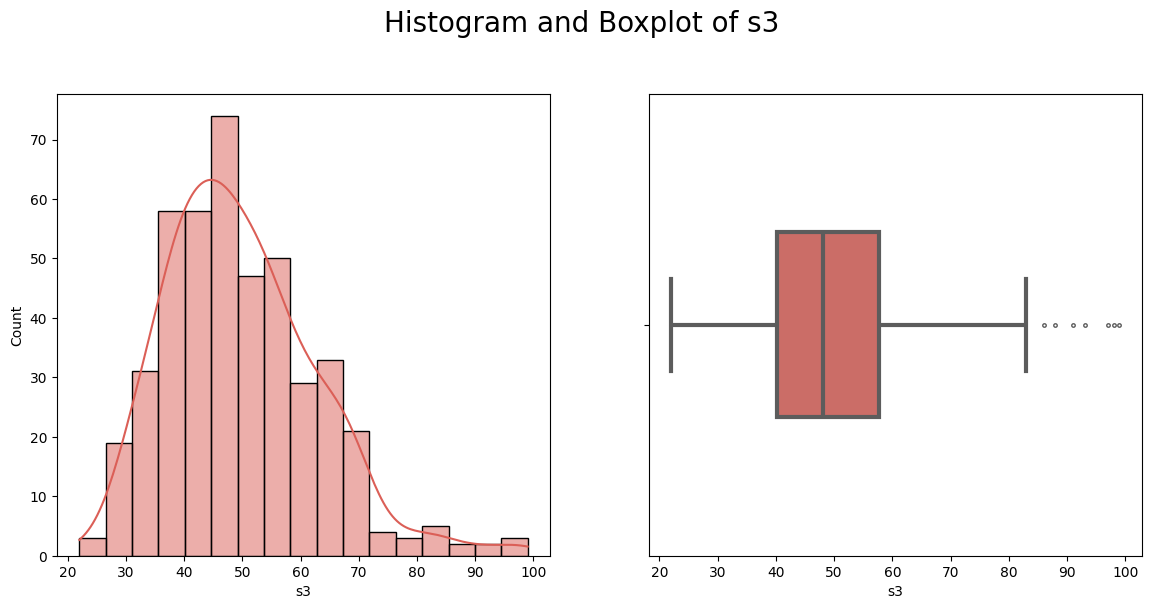

In [32]:
for idx, col in enumerate(['s3']):
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
  sns.histplot(diabetes,x=diabetes[col],kde=True,color=sns.color_palette("hls",len(['s3']))[idx],ax=ax1)
  sns.boxplot(x=diabetes[col],width=0.4,linewidth=3,fliersize=2.5,color=sns.color_palette("hls",len(['s3']))[idx],ax=ax2)
  fig.suptitle(f"Histogram and Boxplot of {col}",size=20,y=1.02)
  plt.show()


#Normality test of s3

In [37]:
stat , p = shapiro(x_train['s3'])
print("stat = %.3f, p=%.3f"%(stat,p))

alpha = 0.05
if p > alpha:
  print("Sample looks normally distributed (fail to reject H0)")
else:
  print("Sample does not look normally distributed (reject H0)")

stat = 0.962, p=0.000
Sample does not look normally distributed (reject H0)


In [39]:
stat, p = shapiro(np.log(x_train['s3']))
print("stat = %.3f, p=%.3f"%(stat,p))
if p > alpha:
  print("Sample looks normally distributed (fail to reject H0)")
else:
  print("Sample does not look normally distributed (reject H0)")

stat = 0.996, p=0.700
Sample looks normally distributed (fail to reject H0)
